In [134]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import pickle
from scipy.sparse import csr_matrix
from lenskit.algorithms.als import BiasedMF


with open("item_embeddings.pkl", "rb") as f:
    trainset_embeddings = pickle.load(f)
with open('entropy_table.pkl', 'rb') as f:
    entropy_table = pickle.load(f)
    

In [2]:
def handle_duplicates(reviews):
    duplicated_pairs = reviews.duplicated(subset=['user', 'item'], keep=False)

    duplicates_df = reviews[duplicated_pairs]

    print(len(duplicates_df))

    combined_reviews = duplicates_df.groupby(['user', 'item']).agg({'rating': 'mean', 'text': ' '.join}).reset_index()

    merged_reviews = pd.merge(reviews, combined_reviews, on=['user', 'item'], how='left', suffixes=('', '_combined'))

    merged_reviews['rating'] = merged_reviews['rating_combined'].fillna(merged_reviews['rating'])
    merged_reviews['text'] = merged_reviews['text_combined'].fillna(merged_reviews['text'])
    merged_reviews = merged_reviews.drop(columns=['rating_combined', 'text_combined'])
    merged_reviews = merged_reviews.drop_duplicates(subset=['user', 'item'])
    
    return merged_reviews





In [3]:
# Setup code

reviews = pd.read_json("mard/mard_reviews.json" , lines=True)
# want to convert to form: user | item | rating | timestamp
reviews=reviews.drop(['helpful', 'summary','reviewTime', 'reviewerName'],axis=1)
reviews=reviews[["reviewerID", 'amazon-id', "overall" ,"unixReviewTime", 'reviewText']]


new_column_names = {'reviewerID': 'user', 'amazon-id': 'item', 'overall': 'rating', "unixReviewTime": "timestamp", "reviewText": "text"}
reviews.rename(columns=new_column_names, inplace=True)

reviews = handle_duplicates(reviews)
reviews

3412


,user,item,rating,timestamp,text
0,A1OFY4ATO7D13W,0026197898,5.0,1355702400,Buy this album. Now. Don't worry about the re...
1,A2KH83L1F70QR8,0026197898,5.0,1358121600,The Sudden Passion did a great job with this o...
2,A1KGXC7IRLVJR3,0615205399,5.0,1214438400,I received this CD as a gift a few weeks ago f...
3,A1BT6LQ9NY6RO3,0615205399,5.0,1214352000,I am a beginner and have tried a couple of med...
4,A206OKO2FE2IPL,0615205399,5.0,1229212800,This is coming from a person that didn't belie...
...,...,...,...,...,...
263520,A3RKUPYX1RC9WO,B00LG9GR3S,5.0,1404777600,What a wonderful CD capturing the unique sound...
263521,A122G17YDFX176,B00LG9GR3S,5.0,1405382400,I love the Smokies! This cd is awesome to lis...
263522,A26QVK35BBBKU8,B00LG9GR3S,5.0,1404777600,Beautiful sounding CD. I felt like I was there...
263523,A1V76VMZ0N3H5W,B00LG9GR3S,5.0,1404864000,This is a really neat collection of sounds fro...


In [111]:
most_popular = reviews['item'].value_counts().iloc[:30].index.tolist()
most_popular = [dataset.mapping()[2][i] for i in most_popular]

In [45]:
trainset_embeddings = {i: e for i, e in trainset_embeddings.items() if e is not None}

dataset = Dataset()
users = reviews['user'].unique()
items = reviews['item'].unique()


print(len(users), len(items))
dataset.fit(users , items)

(interactions, _) = dataset.build_interactions(zip(reviews['user'], reviews['item'], reviews['rating']))

interactions, interactions_test = random_train_test_split(interactions,test_percentage=0.005)


idx_to_id = {i: iid for iid, i in dataset.mapping()[2].items()}

item_embeddings_matrix = csr_matrix([trainset_embeddings.get(item, np.zeros(300)) for item in dataset.mapping()[2]])


187090 64637


In [42]:
a = interactions.getrow(2222).nonzero()[1]
b = np.array([29269, 28811, 28593, 0,2,3,4,5,6,77,777])
len(np.intersect1d(a, b))

3

In [ ]:
valid_labels = set(true_interactions)
pos_label = next(iter(valid_labels), 1)

In [128]:
def get_top_k_recommendations(model, user_indexes, item_features=None, k=30, num_items=64637):
    
    """
    Get the top k recommendations for each user in the LightFM model.

    Parameters:
    - model: LightFM model instance
    - user_indexes: List of user indexes for which recommendations are needed
    - k: Number of recommendations to retrieve for each user (default is 5)

    Returns:
    - recommendations: Dictionary where keys are user indexes and values are lists of recommended item indexes
    """

    recommendations = {}
    n = len(user_indexes)
    all_items = np.arange(num_items)
    

    for i,user_index in enumerate(user_indexes):
        print(f"{i} of {n}", end="\r")
        
        if item_features is not None:
            scores = model.predict(np.full(num_items, user_index), all_items, item_features=item_features)
        else:
            scores = model.predict(np.full(num_items, user_index), all_items)
      
        top_k_items = np.argsort(-scores)[:k]

        recommendations[user_index] = top_k_items.tolist()

    return recommendations

In [129]:
interactions_test

<187090x64637 sparse matrix of type '<class 'numpy.int32'>'
	with 1309 stored elements in COOrdinate format>

In [130]:
# get the rows where interactinos exist in the testset. 
# this will drastically reduce the computation time as 
# I will only evaluate these users instead of all users
# rows = users

nonzero_indices = interactions_test.nonzero()
nonzero_indices_pairs = list(zip(nonzero_indices[0], nonzero_indices[1]))
user_indices = list(set(row_index for row_index, _ in nonzero_indices_pairs))


In [132]:
from collections import Counter
NUM_THREADS = 2

no_comps = [110, 120, 130, 140, 200]

nonzero_indices = interactions_test.nonzero()
nonzero_indices_pairs = list(zip(nonzero_indices[0], nonzero_indices[1]))
user_indices = list(set(row_index for row_index, _ in nonzero_indices_pairs))

metrics = []
for n in no_comps:
    print(f"Evaluating for {n} Components")
    model = LightFM(no_components=n, loss="warp-kos")
    model.fit(interactions, num_threads=NUM_THREADS)
    
    
    recs = get_top_k_recommendations(model, user_indices)
  
    all_recommendations = [item for user_recommendations in recs.values() for item in user_recommendations]

    recommendation_counts = Counter(all_recommendations)

    recommendation_counts_list = list(recommendation_counts.items())

    print("\n\n\n", len(recommendation_counts_list))
    
    precision = calculate_precision(recs, interactions_test)
    ndcg = calculate_ndcg(recs, interactions_test)
    nov = novelty(recs)
    cov = coverage(recs)
    
    scores = {"NDCG@30": ndcg,
             "Precision@30": precision,
             "Coverage": cov,
             "Novelty": nov,
             "Number of Components": n}
    print(scores)
    metrics.append(scores)
    

Evaluating for 110 Components
1282 of 1283


 1138
{'NDCG@30': 0.09747041874826518, 'Precision@30': 0.0034814237464276436, 'Coverage': 0.01760601513065272, 'Novelty': 0.02389211115656547, 'Number of Components': 110}
Evaluating for 120 Components
1282 of 1283


 1168
{'NDCG@30': 0.09775869210240141, 'Precision@30': 0.003403481423746428, 'Coverage': 0.018070145582251652, 'Novelty': 0.023703991240438194, 'Number of Components': 120}
Evaluating for 130 Components
1282 of 1283


 1067
{'NDCG@30': 0.0968683672910914, 'Precision@30': 0.0032995583268381405, 'Coverage': 0.016507573061868588, 'Novelty': 0.023642619335728737, 'Number of Components': 130}
Evaluating for 140 Components
1282 of 1283


 1101
{'NDCG@30': 0.09806111275711124, 'Precision@30': 0.0032735775526110673, 'Coverage': 0.01703358757368071, 'Novelty': 0.023684130861023035, 'Number of Components': 140}
Evaluating for 200 Components
1282 of 1283


 1106
{'NDCG@30': 0.0975520471887789, 'Precision@30': 0.0034554429722005718, 'Covera

In [113]:
# Popularity Recommender
ITEM_ALPHA = 1e-6
NUM_THREADS = 2

nonzero_indices = interactions_test.nonzero()
nonzero_indices_pairs = list(zip(nonzero_indices[0], nonzero_indices[1]))
user_indices = list(set(row_index for row_index, _ in nonzero_indices_pairs))

recs = {u: most_popular for u in user_indices}

precision = calculate_precision(recs, interactions_test)
ndcg = calculate_ndcg(recs, interactions_test)
nov = novelty(recs)
cov = coverage(recs)

scores = {"NDCG@30": ndcg,
         "Precision@30": precision,
         "Coverage": cov,
         "Novelty": nov}
print(scores)
metrics.append(scores)

{'NDCG@30': 0.09515128457266765, 'Precision@30': 0.003091712133021564, 'Coverage': 0.0004641304515989294, 'Novelty': 0.02572009503058634}


In [135]:
scores = [
{'NDCG@30': 0.07019797442336267, 'Precision@30': 5.196154845414393e-05, 'Coverage': 0.016739638287668054, 'Novelty': 0.00014055663144948175, 'Number of Components': 10},
{'NDCG@30': 0.07022769787018947, 'Precision@30': 5.196154845414393e-05, 'Coverage': 0.020096848554233642, 'Novelty': 0.000140499454256256, 'Number of Components': 20},
{'NDCG@30': 0.07012463875148003, 'Precision@30': 2.5980774227071965e-05, 'Coverage': 0.022185435586428826, 'Novelty': 0.0001387808215959545, 'Number of Components': 30},
{'NDCG@30': 0.0701384983008289, 'Precision@30': 5.196154845414393e-05, 'Coverage': 0.023980073332611353, 'Novelty': 0.00014068524262562617, 'Number of Components': 40},
{'NDCG@30': 0.07007546090354083, 'Precision@30': 2.5980774227071965e-05, 'Coverage': 0.024877392205702616, 'Novelty': 0.00013794101444230026, 'Number of Components': 50},
{'NDCG@30': 0.0702545426226154, 'Precision@30': 2.5980774227071965e-05, 'Coverage': 0.027182573448643964, 'Novelty': 0.00013803707931068357, 'Number of Components': 60},
{'NDCG@30': 0.0701663530725254, 'Precision@30': 2.5980774227071965e-05, 'Coverage': 0.027755001005615978, 'Novelty': 0.00013803341561751092, 'Number of Components': 70},
{'NDCG@30': 0.07011071166141955, 'Precision@30': 2.5980774227071965e-05, 'Coverage': 0.027832356080882466, 'Novelty': 0.00013983590065971062, 'Number of Components': 100},
{'NDCG@30': 0.0699190977568928, 'Precision@30': 0.0, 'Coverage': 0.03131333446787444, 'Novelty': 0.00013772936819859052, 'Number of Components': 150}
]
popularity = {'NDCG@30': 0.09515128457266765, 'Precision@30': 0.003091712133021564, 'Coverage': 0.0004641304515989294, 'Novelty': 0.02572009503058634}

cf = [{'NDCG@30': 0.09772671233772903,
  'Precision@30': 0.0033515198752922843,
  'Coverage': 0.0033572102665655893,
  'Novelty': 0.025186781579556256,
  'Number of Components': 10},
 {'NDCG@30': 0.09663694670315122,
  'Precision@30': 0.003403481423746428,
  'Coverage': 0.008833949595432957,
  'Novelty': 0.02478120108281313,
  'Number of Components': 20},
 {'NDCG@30': 0.0968416867117612,
  'Precision@30': 0.003403481423746428,
  'Coverage': 0.011665145350186425,
  'Novelty': 0.02450108772066239,
  'Number of Components': 30},
 {'NDCG@30': 0.0968611637326449,
  'Precision@30': 0.003377500649519356,
  'Coverage': 0.012902826554450237,
  'Novelty': 0.024556005437330573,
  'Number of Components': 40},
 {'NDCG@30': 0.09689432286028485,
  'Precision@30': 0.0034294621979735,
  'Coverage': 0.014233333849033835,
  'Novelty': 0.024425223625954305,
  'Number of Components': 50},
 {'NDCG@30': 0.09889415658975842,
  'Precision@30': 0.0034814237464276436,
  'Coverage': 0.015873261444683387,
  'Novelty': 0.02425740184137754,
  'Number of Components': 60},
 {'NDCG@30': 0.09541467717132554,
  'Precision@30': 0.0032475967783839954,
  'Coverage': 0.01551742809845754,
  'Novelty': 0.023976108163423444,
  'Number of Components': 70},
 {'NDCG@30': 0.09651219222174116,
  'Precision@30': 0.0030657313587944923,
  'Coverage': 0.016058913625322958,
  'Novelty': 0.0235865717977584,
  'Number of Components': 100},
 {'NDCG@30': 0.09747041874826518,
  'Precision@30': 0.0034814237464276436,
  'Coverage': 0.01760601513065272,
  'Novelty': 0.02389211115656547,
  'Number of Components': 110},
 {'NDCG@30': 0.09775869210240141,
  'Precision@30': 0.003403481423746428,
  'Coverage': 0.018070145582251652,
  'Novelty': 0.023703991240438194,
  'Number of Components': 120},
 {'NDCG@30': 0.0968683672910914,
  'Precision@30': 0.0032995583268381405,
  'Coverage': 0.016507573061868588,
  'Novelty': 0.023642619335728737,
  'Number of Components': 130},
 {'NDCG@30': 0.09806111275711124,
  'Precision@30': 0.0032735775526110673,
  'Coverage': 0.01703358757368071,
  'Novelty': 0.023684130861023035,
  'Number of Components': 140},
 {'NDCG@30': 0.0975520471887789,
  'Precision@30': 0.0034554429722005718,
  'Coverage': 0.0171109426489472,
  'Novelty': 0.02348105345872082,
  'Number of Components': 200}]

In [ ]:
from collections import Counter


all_recommendations = [item for user_recommendations in recs.values() for item in user_recommendations]

# Use Counter to count occurrences of each recommendation
recommendation_counts = Counter(all_recommendations)

# Convert the Counter to a list of tuples (item, count)
recommendation_counts_list = list(recommendation_counts.items())

# Print or use the result as needed
print(recommendation_counts_list)

In [ ]:
idx_to_id[49575]

In [16]:
train_item_index_to_id = dict(enumerate(both['item'].unique()))
train_item_id_to_index = {v: k for k, v in train_item_index_to_id.items()}

In [47]:
from sklearn.metrics import ndcg_score, precision_score


def calculate_ndcg(recommendations, interactions_matrix, top_k=30):
    

    true_interactions = np.zeros((len(recommendations), interactions_matrix.shape[1]))

    for i, user_index in enumerate(recommendations.keys()):
        true_interactions[i] = interactions_matrix.getrow(user_index).toarray().flatten()

    binary_relevance = true_interactions.astype(bool).astype(int)

    recommended_items = [recommendations[user_index][:top_k] for user_index in recommendations]

    predicted_relevance = np.zeros_like(binary_relevance)

    for i, user_index in enumerate(recommendations.keys()):
        for j, item in enumerate(recommended_items[i]):
            item_index = item
            if item_index < interactions_matrix.shape[1]:
                predicted_relevance[i, item_index] = top_k - j

    ndcg = ndcg_score(binary_relevance, predicted_relevance)

    return ndcg

def calculate_precision(recommendations, interactions_matrix, k=30):
    precision_values = []

    for user_index, recommended_items in recommendations.items():
        true_interactions = interactions_matrix.getrow(user_index).nonzero()[1]

        top_k_recommendations = np.array(recommended_items[:k])
        
        
        precision = len(np.intersect1d(top_k_recommendations, true_interactions)) / k
        
        precision_values.append(precision)

    avg_precision_at_k = np.mean(precision_values)
    
    return avg_precision_at_k


def novelty(preds, k=30, entropy_table=entropy_table, idx_to_id=idx_to_id):
    novelties = []
    for _, recs in preds.items():
        novelty = np.mean([entropy_table[idx_to_id[i]] for i in recs])
        novelties.append(novelty)
    return np.mean(novelties)

def coverage(preds, train_itemset_length=64637):
    unique_preds = list(set(item for user_recs in preds.values() for item in user_recs))

    return len(unique_preds) / train_itemset_length

In [53]:
content = pd.read_json("mard/mard_metadata.json", lines=True)
content

,price,artist-mbid,imUrl,confidence,categories,release-group-mbid,amazon-id,root-genre,title,artist,label,artist_url,first-release-year,release-mbid,songs,salesRank,related,brand
0,14.23,6ce5815b-b277-48b0-94c9-a87a8f0422b3,http://ecx.images-amazon.com/images/I/6139OLQU...,1.0,"[[CDs & Vinyl, Alternative Rock, Indie & Lo-Fi...",b05be7e9-6bc4-422b-8198-32945b0d1c76,0026197898,Alternative Rock,Southern Fashion,The Sudden Passion,Black Hearts & Pink Parts Records,/s?ie=UTF8&field-artist=The+Sudden+Passion&sea...,2012,359b564b-3db4-44ad-9481-0b45f24aa53e,[{'mbid': '308af531-5fa7-4dd8-969c-6bb7a204eb1...,NaN,NaN,NaN
1,29.98,NaN,http://ecx.images-amazon.com/images/I/51rKlhSe...,NaN,"[[CDs & Vinyl, Alternative Rock, American Alte...",NaN,1902593375,Alternative Rock,Become the Media,Jello Biafra,AK Press,/Jello-Biafra/e/B000APYL8M,NaN,NaN,NaN,{'Music': 902130},NaN,NaN
2,7.18,eb0cd72f-0235-47ec-9d0b-f244a2afc3b7,http://ecx.images-amazon.com/images/I/51x8skEG...,1.0,"[[CDs & Vinyl, Alternative Rock]]",bc2acb6a-4998-3cd3-97e2-61025ed8a562,630251228X,Alternative Rock,Exile,Geoffrey Oryema,emi france,/Geoffrey-Oryema/e/B000APWJ7M,1990,2bbfcc1d-d1a3-460c-bb45-ca1b2b48c8c4,[{'mbid': '2995847a-95ce-4182-aebd-92499e98f73...,{'Music': 530408},"{'also_bought': ['B000000HOX', 'B008B2IJ02', '...",NaN
3,16.18,NaN,http://ecx.images-amazon.com/images/I/217zrfsw...,NaN,"[[CDs & Vinyl, Alternative Rock]]",NaN,B00000007O,Alternative Rock,Stories of the New West,Kent 3,Super Electro,/Kent-3/e/B000APW5GM,NaN,NaN,NaN,{'Music': 776497},NaN,NaN
4,NaN,b0a16d0c-3d99-487d-be88-902131ad03d3,http://ecx.images-amazon.com/images/I/51OK3665...,1.0,"[[CDs & Vinyl, Alternative Rock, Indie & Lo-Fi...",410326cf-4a38-35d3-93d9-a63f8fb77b5b,B0000004JL,Alternative Rock,Wesley Willis,Wesley Willis,Fuse Records,/Wesley-Willis/e/B000APWAAI,1995,d22e418c-679d-42c0-991f-7ca12df854e8,[{'mbid': '0dccf187-7b1e-47a0-8b44-1844b9243ee...,{'Music': 844130},"{'also_viewed': ['B00004Y6SW', 'B000002MBE', '...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65561,NaN,NaN,http://ecx.images-amazon.com/images/I/51gUgd65...,NaN,"[[CDs & Vinyl, Folk]]",NaN,B00IDQOHRK,Folk,Letters from the Moon,Eva and the Vagabond Tales,Eva and the Vagabond Tales,/s?ie=UTF8&field-artist=Eva+and+the+Vagabond+T...,NaN,NaN,NaN,{'Music': 1287639},NaN,NaN
65562,NaN,NaN,http://ecx.images-amazon.com/images/I/51scxHVX...,NaN,"[[CDs & Vinyl, Folk]]",NaN,B00JGBB1QQ,Folk,Tales from the Bonus Round,Steve Schalchlin,Bonus Round,/s?ie=UTF8&field-artist=Steve+Schalchlin&searc...,NaN,NaN,NaN,{'Music': 689056},NaN,NaN
65563,NaN,67776697-0ce5-476a-a763-b3d0548bad41,http://ecx.images-amazon.com/images/I/61K-QN%2...,1.0,"[[CDs & Vinyl, Folk, Contemporary Folk]]",ec1679c5-f305-3417-8a5f-22b53daac37c,B00JH1E0K4,Folk,Echo,After Jack,Travianna Records,/s?ie=UTF8&field-artist=After+Jack&search-alia...,,8f9c7963-d86d-4f92-88d7-989448bc2aee,[{'mbid': '276034ea-e4ba-433f-bfde-c1c03753009...,{'Music': 313501},"{'also_viewed': ['B00IGL2O9K', 'B00IMUXK2K', '...",NaN
65564,NaN,NaN,http://ecx.images-amazon.com/images/I/51TtZJ6-...,NaN,"[[CDs & Vinyl, Folk]]",NaN,B00JJCCQTI,Folk,Let's Move the World,Lila Garrett & Keaton Simons,Lila Garrett & Keaton Simons,/s?ie=UTF8&field-artist=Lila+Garrett+%26+Keato...,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
idx_to_id_user = {i: iid for iid, i in dataset.mapping()[0].items()}

In [81]:
model = LightFM(no_components=60, loss="warp", item_alpha=1e-6)
model.fit(interactions, item_features=item_embeddings_matrix, num_threads=NUM_THREADS)

In [104]:
user_idx = 953
user_id = idx_to_id_user[user_idx]
amazon_ids = reviews[reviews['user'] == user_id]['item'].tolist()
content[content['amazon-id'].isin(amazon_ids)][['artist', 'title', 'root-genre', "amazon-id"]]

,artist,title,root-genre,amazon-id
54114,Rush,Clockwork Angels: UK Fan Pack,Rock,1858705231


In [105]:
recs = get_top_k_recommendations(model, [user_idx], item_embeddings_matrix)
print(recs)
rec_amazon_ids = [idx_to_id[i] for i in recs[user_idx]]
content[content['amazon-id'].isin(rec_amazon_ids)][['artist', 'title', 'root-genre']]

64637 64637
{953: [58709, 49977, 32680, 64131, 56121, 59173, 6220, 22309, 25973, 44950, 47795, 50466, 44511, 61601, 12431, 47725, 36275, 20181, 25811, 52971, 3407, 33135, 33578, 64230, 51212, 61111, 57753, 18965, 28924, 42243]}


,artist,title,root-genre
2226,Pylon,Chomp,Alternative Rock
3109,#1 Beatles Reggae Band,Beatles Summertime Reggae Party,Reggae
15279,Columbus L Bridges,Diana Dynasty of Funk,R&B
18388,Brian Tarquin,Ghost Dance,Jazz
20913,Tok Tok Tok,Ruby Soul,Jazz
23478,Anthony Davis,I've Known Rivers,Jazz
25437,アビガー,Anticlockwise,Metal
25929,Manilla Road,Mystification,Metal
26147,Lord Weird Slough Feg,Down Among The Dead Men,Metal
26691,Jar'd Loose,Goes to Purgatory,Metal


(0.0, 0.013481423746427645)

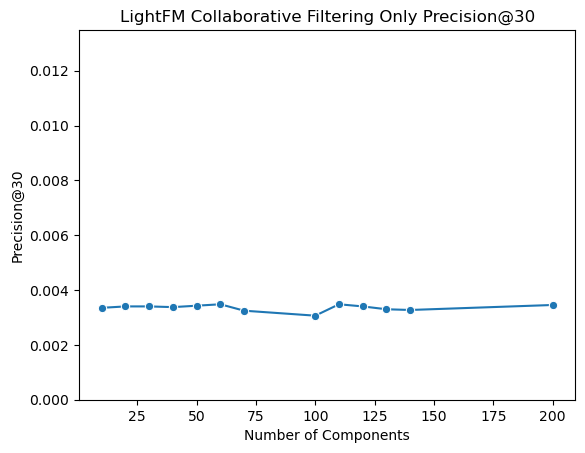

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
cf = pd.DataFrame(cf)

sns.lineplot(x="Number of Components", y="Precision@30", marker="o", data=cf)
plt.title("LightFM Collaborative Filtering Only Precision@30")
plt.ylim(0, max(cf['Precision@30']) + 0.01)


(0.0, 0.10889415658975841)

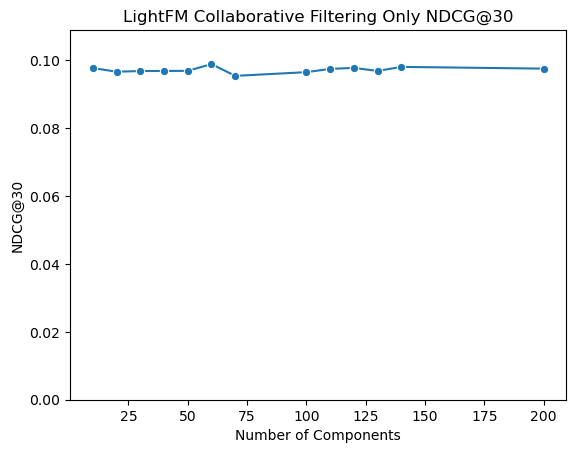

In [142]:
sns.lineplot(x="Number of Components", y="NDCG@30", marker="o", data=cf)
plt.title("LightFM Collaborative Filtering Only NDCG@30")
plt.ylim(0, max(cf['NDCG@30']) + 0.01)


(0.0, 0.11807014558225165)

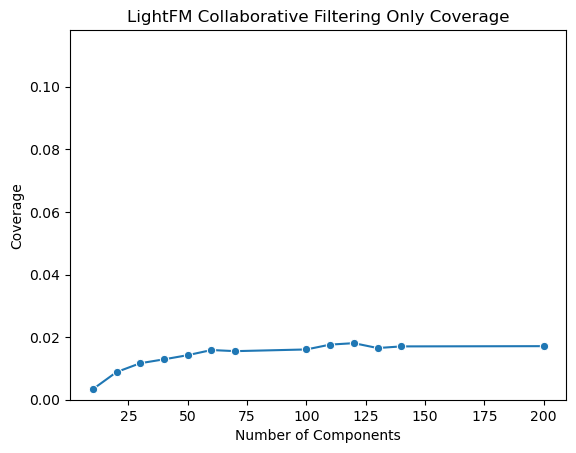

In [139]:
sns.lineplot(x="Number of Components", y="Coverage", marker="o", data=cf)
plt.title("LightFM Collaborative Filtering Only Coverage")
plt.ylim(0, max(cf['Coverage']) + 0.1)


(0.0, 0.028070145582251654)

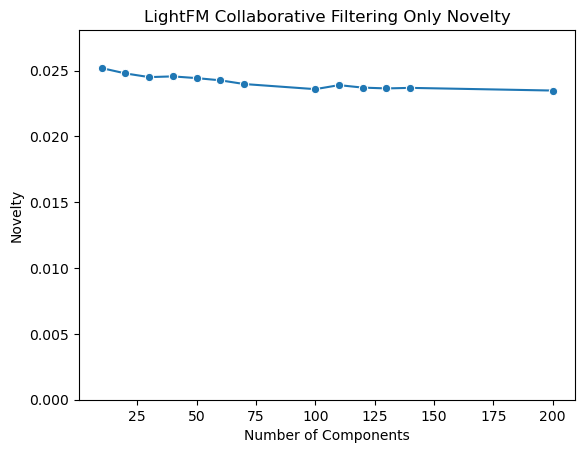

In [141]:
sns.lineplot(x="Number of Components", y="Novelty", marker="o", data=cf)
plt.title("LightFM Collaborative Filtering Only Novelty")
plt.ylim(0, max(cf['Coverage']) + 0.01)


(0.0, 0.13131333446787444)

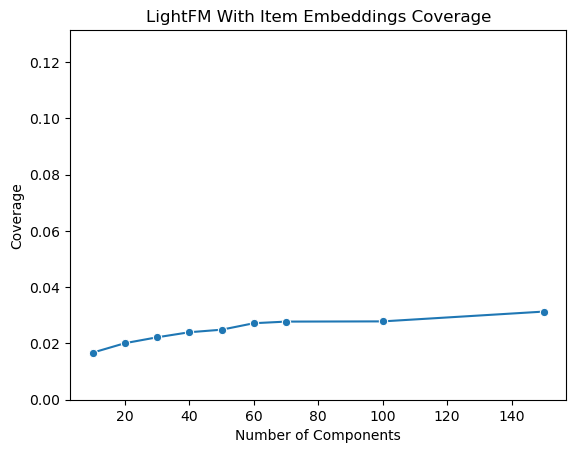

In [149]:
cf = pd.DataFrame(scores)
sns.lineplot(x="Number of Components", y="Coverage", marker="o", data=cf)
plt.title("LightFM With Item Embeddings Coverage")
plt.ylim(0, max(cf['Coverage']) + 0.1)

(0.0, 0.1702545426226154)

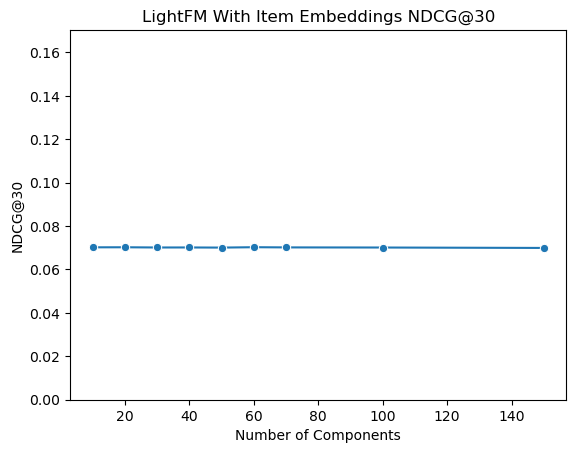

In [150]:
sns.lineplot(x="Number of Components", y="NDCG@30", marker="o", data=cf)
plt.title("LightFM With Item Embeddings NDCG@30")
plt.ylim(0, max(cf['NDCG@30']) + 0.1)

(0.0, 0.00015196154845414393)

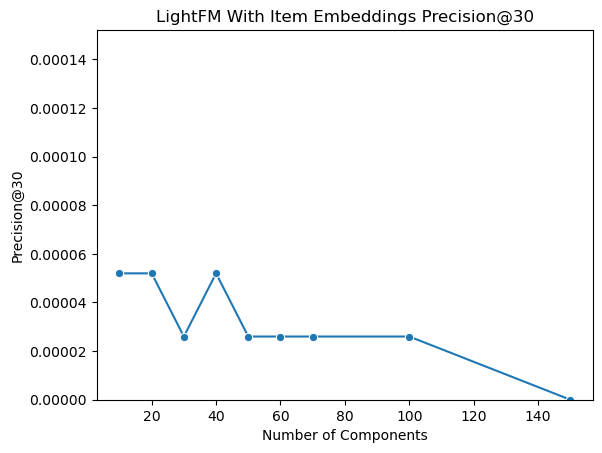

In [155]:
sns.lineplot(x="Number of Components", y="Precision@30", marker="o", data=cf)
plt.title("LightFM With Item Embeddings Precision@30")
plt.ylim(0, max(cf['Precision@30']) + 0.0001)

(0.0, 0.0006406852426256262)

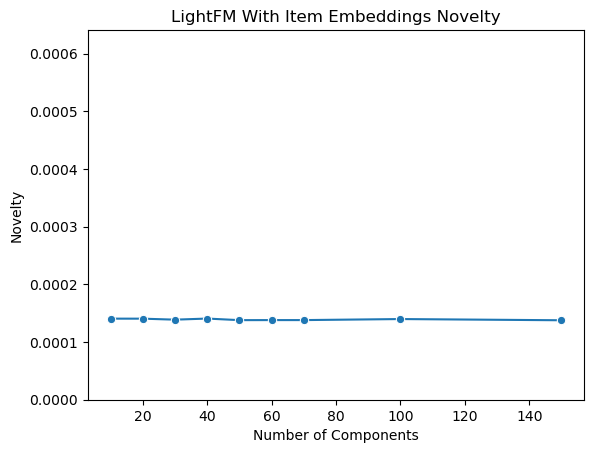

In [154]:
sns.lineplot(x="Number of Components", y="Novelty", marker="o", data=cf)
plt.title("LightFM With Item Embeddings Novelty")
plt.ylim(0, max(cf['Novelty']) + 0.0005)